In [176]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [177]:
api = KaggleApi()
api.authenticate()

In [178]:
api.competition_download_files('titanic', path='.')

In [179]:
if os.path.exists('/titanic'):
    with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
        zip_ref.extractall('titanic')

In [180]:
X = pd.read_csv('titanic/train.csv')
X = X.drop(columns=('Cabin'))

In [181]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB


In [182]:
X.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


In [183]:
class AddPersonTitle(BaseEstimator, TransformerMixin):
    def __init__(self):
        self = self
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(
            {
                "Title" : X['Name'].apply(lambda name:(
                    "Mr" if "Mr." in name or "Don." in name else 
                    "Mrs" if "Mrs." in name else
                    "Miss" if "Miss." in name else
                    "Master" if "Master." in name else
                    "Other"
                )                                          
                    
                )
            }
        )
    

In [184]:
class AgeRestorer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
        else: 
            X_values = X
        self.scaler.fit(X_values)
        return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_columns = X.columns
            X_index = X.index
            X_values = X.values
        else :
            X_values = X
            X_columns = None
            X_index = None

        scaled = self.scaler.transform(X_values)
        original = self.scaler.inverse_transform(scaled)

        if X_columns is not None:
            result_df = pd.DataFrame(original, columns=X_columns, index=X_index)
        else:
            result_df = pd.DataFrame(original)

        if 'Age' in result_df.columns:
            result_df['Age'] = result_df['Age'].astype(np.int32)
        else:
            result_df.iloc[:, 0] = result_df.iloc[:, 0].astype(np.int32)

        return result_df.values

In [185]:

def num_pipeline_void(X):
    num_pipeline = Pipeline(
        [
            ("imputer", KNNImputer(n_neighbors=5, weights='distance')),
            ("restore_age", AgeRestorer())
        ]
    )
    preprocessor_num = ColumnTransformer(
        [
            ("num", num_pipeline, ['Age'])
        ]
    )
    X_transformed_num = preprocessor_num.fit_transform(X)
    return X_transformed_num

def cat_pipeline_void(X):
    cat_pipeline = Pipeline(
        [
            ("one_hot", OneHotEncoder(sparse_output=False))
        ]
    )

    title_pipeline = Pipeline(
        [
            ("extract_title", AddPersonTitle()),
            ("one_hot", OneHotEncoder(sparse_output=False))
        ]
    )
    preprocessor_cat = ColumnTransformer(
        [
            ("title", title_pipeline, ['Name']),
            ("cat", cat_pipeline, ['Embarked', 'Sex'])
        ]
    )

    X_transformed_cat = preprocessor_cat.fit_transform(X)
    
    title_cols = preprocessor_cat.named_transformers_["title"] \
                .named_steps["one_hot"] \
                .get_feature_names_out(["Title"])
    cat_cols = preprocessor_cat.named_transformers_["cat"] \
               .named_steps["one_hot"] \
               .get_feature_names_out(["Embarked", "Sex"])
    
    all_features_names = np.concatenate([title_cols, cat_cols])
    cat_df = pd.DataFrame(X_transformed_cat, columns=all_features_names)
    return cat_df

In [186]:
numerical_cats = ['PassengerId', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 
                  'Title_Other', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Sex_female', 'Sex_male']

In [187]:
X = pd.read_csv('titanic/train.csv')
cat_df = cat_pipeline_void(X)
num_df = num_pipeline_void(X)
X = X.drop(columns=('Cabin'))
X = X.drop(columns=('Embarked'))
X = X.drop(columns=('Sex'))
X['Age'] = num_df
X = pd.concat([X, cat_df], axis=1)

X_copy = X.copy()
filter_cols = [col for col in numerical_cats if 'Survived' not in col]
X_testing = np.array(X_copy.select_dtypes(include='number').drop(columns=('Survived')).drop(columns=('Embarked_nan')))
y_testing = np.array(X['Survived'])

In [188]:
X_testing

array([[  1.,   3.,  22., ...,   1.,   0.,   1.],
       [  2.,   1.,  38., ...,   0.,   1.,   0.],
       [  3.,   3.,  26., ...,   1.,   1.,   0.],
       ...,
       [889.,   3.,  29., ...,   1.,   1.,   0.],
       [890.,   1.,  26., ...,   0.,   0.,   1.],
       [891.,   3.,  32., ...,   0.,   0.,   1.]], shape=(891, 16))

In [189]:
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.3, random_state=42)
for train_index, test_index in sss.split(X_testing, y_testing):
    X_train, X_test = X_testing[train_index], X_testing[test_index]
    y_train, y_test = y_testing[train_index], y_testing[test_index]

In [190]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_testing, y_testing)

RandomForestClassifier(random_state=42)

In [191]:
cross_val_score(model, X_train, y_train, cv=3)

array([0.85096154, 0.83173077, 0.82608696])

In [192]:
y_pred = cross_val_predict(model, X_train, y_train)

In [193]:
con_matrix = confusion_matrix(y_train, y_pred)

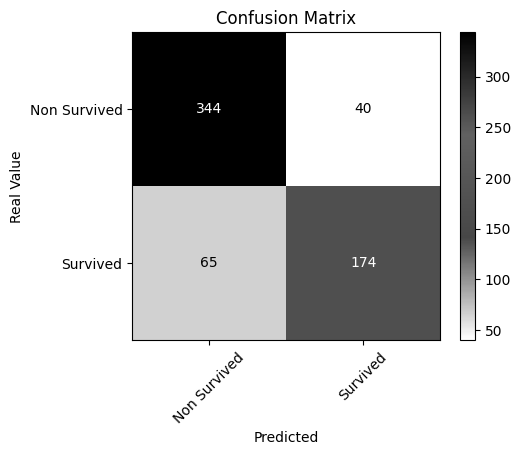

In [194]:
plt.figure(figsize=(5,4))
custom_cmap = LinearSegmentedColormap.from_list('custom', ['#ffffff', '#474747', '#616161', '#000000'])
plt.imshow(con_matrix, interpolation='nearest', cmap=custom_cmap)
plt.colorbar()
targets = np.array(['Non Survived', 'Survived'])
targets_pos = np.arange(len(targets))
plt.xticks(targets_pos, targets, rotation=45)
plt.yticks(targets_pos, targets)
plt.ylabel('Real Value')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
thresh = con_matrix.max() / 2 
for i in range(con_matrix.shape[0]):
    for j in range(con_matrix.shape[1]):
        plt.text(j , i, format(con_matrix[i, j], 'd'),
        ha='center', va='center', 
        color='white' if con_matrix[i, j] > thresh else 'black')

In [204]:
X = pd.read_csv('titanic/test.csv')
index = X['PassengerId']
cat_df = cat_pipeline_void(X)
num_df = num_pipeline_void(X)
X = X.drop(columns=('Cabin'))
X = X.drop(columns=('Embarked'))
X = X.drop(columns=('Sex'))
X['Age'] = num_df
X = pd.concat([X, cat_df], axis=1)
X = np.array(X.select_dtypes(include='number'))
predictions = model.predict(X)
output = pd.DataFrame({'PassengerId': index, 'Survived': predictions})
output.to_csv('submission.csv', index=False)

AttributeError: 'numpy.ndarray' object has no attribute 'isnull'